In [1]:
import pandas as pd
import numpy as np
from numpy.random import default_rng
from matplotlib import pyplot as plt

# Introduction
This notebook explores the classic percolation model for bushfire modelling and considers the Poisson distribution later.

In [2]:
def create_lattice(p, N, mode):
    rng = default_rng()
        
    if mode == 'bernoulli':
        x = rng.uniform(low=0, high=1, size=(N, N))
        y = x < p
    elif mode == 'poisson':
        y = rng.poisson(lam=p, size=(N, N))
    return y.astype(int)

# check if node contains fuel
def burnable(node, lattice):
    return lattice[node] > 0

# returns false if index is outside of lattice
def in_lattice(index, lattice):
    m, n = lattice.shape
    i, j = index
    if not 0 <= i <= m-1 or not 0 <= j <= n-1:
        return False
    else:
        return True

def get_neighbours(node, lattice):
    # get neighbours based on reach, i.e. node value
    # same for bernoulli and poisson modes, reach = L_inf distance
    nbs = []
    i, j = node
    reach = lattice[node]
#     k + l <= reach
    for k in range(reach + 1):
        for l in range(reach + 1 - k):
            for signk in [-1, 1]:
                for signl in [-1, 1]:
                    nb = (i + signk*k, j + signl* l)
                    if in_lattice(nb, lattice):
                        nbs.append(nb)
            
    # remove duplicates from k=0 or l=0
    nbs = list(set(nbs))
    # remove original node, case k=l=0
    if node in nbs:
        nbs.remove(node)
    return nbs
    
    

In [3]:
def simulate(p, N, mode):
    # initialize
    lattice = create_lattice(p, N, mode)
    matrices = [np.copy(lattice)]
    
    front = []
    archive = []
    
    # add burnable nodes in top row to front
    I, J = np.where(lattice[:1] > 0)
    for index in zip(I, J):
        front.append(index)
        
    # spread fire until front is emtpy
    while front:
        new_front = []
        
        for node in front:
            # get neighbours before burning
            nbs = get_neighbours(node, lattice)
            lattice[node] = -1
            
            # add burnable neighbours to new front
            for nb in nbs:
                if not nb in front and not nb in archive and burnable(nb, lattice):
                    new_front.append(nb)
        
        # update archive
        archive = archive + front
        # update front
        front = new_front
        
        # save snapshot of current lattice
        mat = np.copy(lattice)
        matrices.append(mat)
        
    return matrices

In [4]:
mats = simulate(.5, 30, 'bernoulli')

# Plotting and Animating

## Create Custom Color Map

In [5]:
from matplotlib import cm
from matplotlib import colors
from matplotlib.colors import ListedColormap

In [6]:
red = np.array([colors.to_rgba('firebrick')])
brown = np.array([colors.to_rgba('orange')])
greens = cm.get_cmap('Greens', 256)
newcolors = greens(np.linspace(0, 1, 256))


In [7]:
newcolors[:25, :] = red
newcolors[25:129, :] = brown
newcmp = ListedColormap(newcolors)

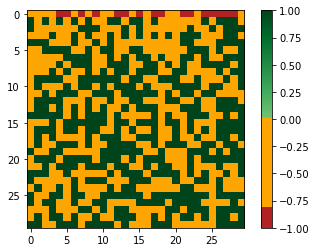

In [8]:
plt.imshow(mats[1], cmap = newcmp, vmin = -1)
plt.colorbar()

# Create Animation

In [9]:
from matplotlib.animation import FuncAnimation

In [10]:
import matplotlib.animation as animation
from IPython import display

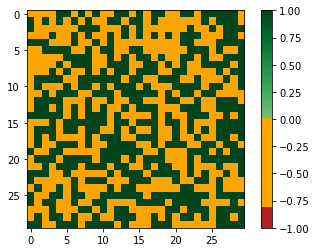

In [12]:
ims = []
fig, ax = plt.subplots()
for i, mat in enumerate(mats):
    im = plt.imshow(mat, cmap = newcmp, vmin = -1, animated=True)
    
    # 
    if i==0:
        im = plt.imshow(mat, cmap = newcmp, vmin = -1, animated=True)
        plt.colorbar()
    ims.append([im])

anim = animation.ArtistAnimation(fig, ims, interval=300, blit=True,
                                repeat_delay=1000)
plt.show()

In [13]:

ani = animation.ArtistAnimation(fig, ims, interval=50,
                               repeat_delay=1000)
video = ani.to_html5_video()
html = display.HTML(video)
display.display(html)
